# Bahdanau 注意力



In [1]:
import sys
sys.path.append('..')

In [2]:
import mindspore
import mindspore.nn as nn
import mindspore.numpy as mnp
from d2l import mindspore as d2l

带有注意力机制的解码器基本接口

实现带有Bahdanau注意力的循环神经网络解码器

In [3]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0., **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Dense(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.transpose(1, 0, 2), hidden_state, enc_valid_lens)

    def construct(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).transpose(1, 0, 2)
        outputs, attention_weights = [], []
        for i in range(X.shape[0]):
            x = X[i]
            query = mnp.expand_dims(hidden_state[-1], axis=1)
            context, attention_weight = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            x = mnp.concatenate((context, mnp.expand_dims(x, axis=1)), axis=-1)
            out, hidden_state = self.rnn(x.transpose(1, 0, 2), hidden_state)
            outputs.append(out)
            attention_weights.append(attention_weight)
        outputs = self.dense(mnp.concatenate(outputs, axis=0))
        return outputs.transpose(1, 0, 2), (enc_outputs, hidden_state,
                                          enc_valid_lens), attention_weights

测试Bahdanau注意力解码器

In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.set_train(False)
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.set_train(False)
X = mnp.zeros((4, 7), dtype=mindspore.int32)
state = decoder.init_state(encoder(X), None)
output, state, attention_weights = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

((4, 7, 10), 2, (4, 7, 16), 2, (4, 16))

训练

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 250

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

将几个英语句子翻译成法语

loss 0.019, 4250.1 tokens/sec


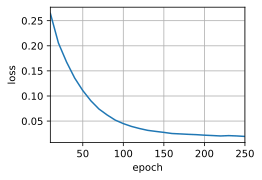

In [6]:
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab)

In [7]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

ValueError: too many values to unpack (expected 2)

In [ ]:
attention_weights = mnp.concatenate([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

可视化注意力权重

In [ ]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1],
    xlabel='Key positions', ylabel='Query positions')